# Identifiera Fake News

Mål:

Målet med projektet är att skapa en klassificeringsmodell som kan skilja mellan sanna och falska nyhetsartiklar.

Dataset:

För detta projekt kommer jag att använda datasetet "Fake News Detection" från Kaggle. Det innehåller artiklar från olika källor, märkta som antingen sanna eller falska.

Datasetets egenskaper:

* Antal rader: 20,800+
* Kolumner:
    * `id`: Unikt identifieringsnummer för artikeln
    * `title`: Titel på artikeln
    * `author`: Författare till artikeln
    * `text`: Själva artikeln
    * `label`: Klassifikation av artikeln (0 = sann, 1 = falsk)


---

## Bearbeta dataset

### Ladda Data

In [1]:
import pandas as pd

data = pd.read_csv('dataset/train.csv')

print(data.head())

   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1  


Skapa Validation Data

In [2]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_data.to_csv('dataset/train_data.csv', index=False)
val_data.to_csv('dataset/val_data.csv', index=False)


Ladda dataset

In [3]:
train_data = pd.read_csv('dataset/train_data.csv')
val_data = pd.read_csv('dataset/val_data.csv')
test_data = pd.read_csv('dataset/test.csv')

print(train_data.head())
print(val_data.head())
print(test_data.head())

      id                                              title  \
0   5933  Raccoons in Central Park Draw Crowds, and Warn...   
1   9646  Bolton on Susan Rice Scandal: Obama Needs to B...   
2   8642  IF HILLARY CLINTON IS CHARGED WITH OBSTRUCTION...   
3  15126  New York Times’s Moscow Bureau Was Targeted by...   
4   3410  Gays Against Sharia March Branded ’Islamophobi...   

                                author  \
0                     Sarah Maslin Nir   
1                         John Hayward   
2                           Iron Sheik   
3  Nicole Perlroth and David E. Sanger   
4                 Donna Rachel Edmunds   

                                                text  label  
0  Like a little crew of   bandits, the first few...      0  
1  On Thursday’s Breitbart News Daily, SiriusXM h...      0  
2  Home › POLITICS › IF HILLARY CLINTON IS CHARGE...      1  
3  The New York Times’s Moscow bureau was the tar...      0  
4  An event organised by Gays Against Sharia to m...      

### Inspektera Data

In [4]:
train_data.info()
val_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16640 entries, 0 to 16639
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      16640 non-null  int64 
 1   title   16182 non-null  object
 2   author  15066 non-null  object
 3   text    16610 non-null  object
 4   label   16640 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 650.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4160 entries, 0 to 4159
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      4160 non-null   int64 
 1   title   4060 non-null   object
 2   author  3777 non-null   object
 3   text    4151 non-null   object
 4   label   4160 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 162.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 


Komplettera saknade värden inom "title", "author" och "text"

In [5]:
# training data
train_data['title'] = train_data['title'].fillna('missing')
train_data['author'] = train_data['author'].fillna('unknown')
train_data['text'] = train_data['text'].fillna('missing')

# testing data
test_data['title'] = test_data['title'].fillna('missing')
test_data['author'] = test_data['author'].fillna('unknown')
test_data['text'] = test_data['text'].fillna('missing')

# validation data
val_data['title'] = val_data['title'].fillna('missing')
val_data['author'] = val_data['author'].fillna('unknown')
val_data['text'] = val_data['text'].fillna('missing')

### Preprocessing av text data

Små bokstäver: Konvertera all text till små bokstäver för att säkerställa enhetlighet.  
Ta bort specialtecken och siffror: Förenkla texten till bara ord. 

In [7]:
import re

def clean_text(text):
    text = text.lower()  # konvertera till lowercase
    text = re.sub(r'\d+', '', text)  # ta bort siffror
    text = re.sub(r'\s+', ' ', text).strip()  # ta bort extra mellanslag
    text = re.sub(r'[^\w\s]', '', text)  # ta bort specialtecken
    return text


train_data['clean_text'] = train_data['text'].apply(clean_text)
test_data['clean_text'] = test_data['text'].apply(clean_text)
val_data['clean_text'] = val_data['text'].apply(clean_text)


Tokenisering: Bryt ner texten till enskilda ord.  

In [8]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

train_data['tokens'] = train_data['clean_text'].apply(tokenize_text)
test_data['tokens'] = test_data['clean_text'].apply(tokenize_text)
val_data['tokens'] = val_data['clean_text'].apply(tokenize_text)

[nltk_data] Downloading package punkt to /Users/carolina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Ta bort stoppord: Det här är vanliga ord (som "the", "a", "in") som troligen inte är till hjälp i analysen.  

In [9]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

train_data['filtered_tokens'] = train_data['tokens'].apply(remove_stopwords)
test_data['filtered_tokens'] = test_data['tokens'].apply(remove_stopwords)
val_data['filtered_tokens'] = val_data['tokens'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carolina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Stamma eller lemmatisera: Reducera ord till deras bas- eller rotform.  

In [10]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized

train_data['lemmatized_tokens'] = train_data['filtered_tokens'].apply(lemmatize_tokens)
test_data['lemmatized_tokens'] = test_data['filtered_tokens'].apply(lemmatize_tokens)
val_data['lemmatized_tokens'] = val_data['filtered_tokens'].apply(lemmatize_tokens)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/carolina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Vektorisering: Konvertera den bearbetade texten till numeriska värden.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Sammanfoga tokens tillbaka till strängar
train_data['final_text'] = train_data['lemmatized_tokens'].apply(lambda x: ' '.join(x))
test_data['final_text'] = test_data['lemmatized_tokens'].apply(lambda x: ' '.join(x))
val_data['final_text'] = val_data['lemmatized_tokens'].apply(lambda x: ' '.join(x))

# Initialisera och tillämpa TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(train_data['final_text'])
X_test = vectorizer.transform(test_data['final_text'])
X_val = vectorizer.transform(val_data['final_text'])

# Målvariabeln
y_train = train_data['label']
y_val = val_data['label']


Spara bearbetad data

In [14]:
train_data.to_csv('processed-dataset/train_processed.csv', index=False)
test_data.to_csv('processed-dataset/test_processed.csv', index=False)
val_data.to_csv('processed-dataset/val_processed.csv', index=False)


---

## Träna Modellen

### Konfigurering av Random Forest-modellen

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


# Assuming you've already vectorized your text data into X_train and y_train
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(train_data['final_text'])
y_train = train_data['label']
X_val = vectorizer.transform(val_data['final_text'])
y_val = val_data['label']
X_test = vectorizer.transform(test_data['final_text'])

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can tune these parameters

# Train the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

### Utvärdering av modellen

In [23]:
# training data
train_predictions = rf_model.predict(X_train)
print("Training Accuracy: ", accuracy_score(y_train, train_predictions))
print(classification_report(y_train, train_predictions))

# validation data
val_predictions = rf_model.predict(X_val)
print("Validation Accuracy: ", accuracy_score(y_val, val_predictions))
print(classification_report(y_val, val_predictions))


Training Accuracy:  0.9998798076923077
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8255
           1       1.00      1.00      1.00      8385

    accuracy                           1.00     16640
   macro avg       1.00      1.00      1.00     16640
weighted avg       1.00      1.00      1.00     16640

Validation Accuracy:  0.9288461538461539
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2132
           1       0.93      0.92      0.93      2028

    accuracy                           0.93      4160
   macro avg       0.93      0.93      0.93      4160
weighted avg       0.93      0.93      0.93      4160



Dubbelkolla att modellen inte gör overfitting

In [21]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validated scores:", scores)
print("Average score:", scores.mean())


Cross-validated scores: [0.91826923 0.9233774  0.92097356 0.92157452 0.92427885]
Average score: 0.9216947115384615


### Confusion Matrix

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
# Confusion matrix - training data
train_conf_matrix = confusion_matrix(y_train, train_predictions)
print("Confusion Matrix - Training Data:")
print(train_conf_matrix)

# Confusion matrix - validation data
val_conf_matrix = confusion_matrix(y_val, val_predictions)
print("Confusion Matrix - Validation Data:")
print(val_conf_matrix)


Confusion Matrix - Training Data:
[[8253    2]
 [   0 8385]]
Confusion Matrix - Validation Data:
[[1993  139]
 [ 157 1871]]


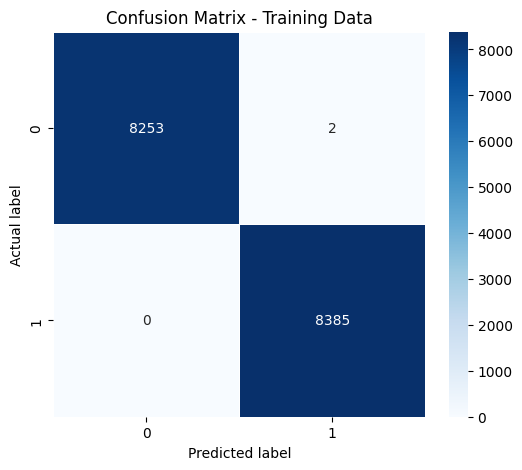

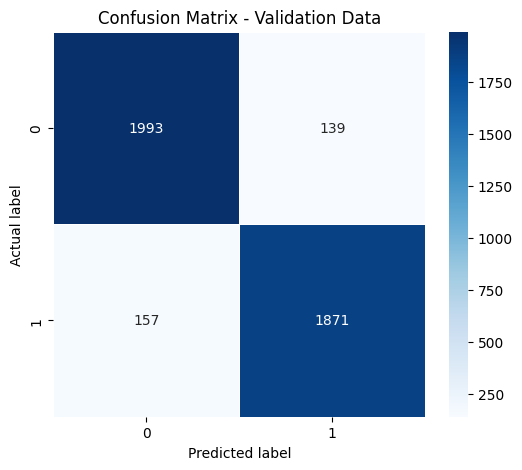

In [28]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(title)

# Plot for training set
plot_confusion_matrix(train_conf_matrix, "Confusion Matrix - Training Data")

# Plot for validation set
plot_confusion_matrix(val_conf_matrix, "Confusion Matrix - Validation Data")

plt.show()


In [29]:
print(classification_report(y_val, val_predictions))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2132
           1       0.93      0.92      0.93      2028

    accuracy                           0.93      4160
   macro avg       0.93      0.93      0.93      4160
weighted avg       0.93      0.93      0.93      4160



---

## Förutsägelser för test data

In [30]:
test_predictions = rf_model.predict(X_test)
test_data['predictions'] = test_predictions
test_data[['id', 'predictions']].to_csv('test_predictions.csv', index=False)
